In [1]:
import pandas as pd
df = pd.read_csv('Rforest_centrocampistas.csv')

df.head()

,value,age,MP,X90s,Goals,Shots,SoT,SoT.,G.Sh,G.SoT,...,Fld,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon.,G.MP
0,15.0,21,16,10.8,3,1.11,0.37,33.3,0.17,0.50,...,3.06,0.19,0.00,0.00,0.0,4.44,0.83,1.67,33.3,0.277778
1,10.0,26,21,20.3,0,1.23,0.54,44.0,0.00,0.00,...,1.28,0.00,0.00,0.00,0.0,4.78,0.44,0.25,64.3,0.000000
2,20.0,22,18,11.5,4,2.96,1.13,38.2,0.12,0.31,...,2.78,0.09,0.09,0.09,0.0,5.22,0.00,0.87,0.0,0.347826
3,3.0,31,19,13.6,3,0.88,0.51,58.3,0.17,0.29,...,0.88,0.00,0.00,0.00,0.0,4.49,0.66,1.32,33.3,0.220588
4,2.5,26,5,1.5,0,0.67,0.00,0.0,0.00,0.00,...,2.00,0.00,0.00,0.00,0.0,3.33,1.33,1.33,50.0,0.000000


# Mejores Hiperparámetros

In [2]:
# Búsqueda del mejor valor de cantidad de árboles, ajustado a la profundidad óptima encontrada (4)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px


seed = 123

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['value']), df['value'], test_size=0.2, random_state=seed)


maxdepth_list = []
min_samples_list = []
nestimator_list = []
max_leaf_nodes_list = []
MAPE_test_list = []
MAE_CV_list = []

max_depth = [5, 10, 15]
min_samples_split = [2, 5, 10, 20]
max_leaf_nodes = [5, 10, 20, 30]
estimators = [50, 100, 200, 300]

for maxdepth in max_depth:
  for n_estimators in estimators:
    for samples in min_samples_split:
      for leaf_nodes in max_leaf_nodes:
        rf_model = RandomForestRegressor(random_state=seed, max_depth=maxdepth, n_estimators=n_estimators, min_samples_split=samples, max_leaf_nodes = leaf_nodes)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        #cross validation CV = 3 / SCORE = MAE
        scores = cross_val_score(rf_model, X_train, y_train, cv=3,scoring='neg_mean_absolute_error')
        mae_scores = -scores

        ## Generación de listas
        maxdepth_list.append(maxdepth)
        nestimator_list.append(n_estimators)
        min_samples_list.append(samples)
        max_leaf_nodes_list.append(leaf_nodes)
        MAPE_test_list.append(mean_absolute_percentage_error(y_test,y_pred))
        MAE_CV_list.append(mae_scores.mean()) # MAE

        df_grid = pd.DataFrame({"maxdepth":maxdepth_list,
                          "n_estimators":nestimator_list,
                           "min_samples":min_samples_list,
                           "max_leaf_nodes":max_leaf_nodes_list,
                           "MAPE_test":MAPE_test_list,
                            "MAE_CV":MAE_CV_list})


min_mae = df_grid["MAE_CV"].idxmin()
print('Los hiperparámetros ajustados al mínimo MAE son:')
print(df_grid.loc[min_mae])

Los hiperparámetros ajustados al mínimo MAE son:
maxdepth           10.000000
n_estimators      200.000000
min_samples         5.000000
max_leaf_nodes     10.000000
MAPE_test           1.470057
MAE_CV             12.903696
Name: 101, dtype: float64


## Grafico mejores parámetros

In [ ]:
fig = px.scatter(df_grid, x="MAE_CV", y="max_leaf_nodes", color="maxdepth",
                 size='min_samples', symbol = 'n_estimators')

fig.update_layout(
    title="Hyperparameter tuning (Centrocampistas)",
    autosize=True,
    width=900,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90),
    legend=dict(orientation="h", x=0.5, y=1.1),
    xaxis_title="Mean Absolute Error (CV)",
    yaxis_title="Max Leaf Nodes",
    coloraxis_colorbar_title="Max Depth",
    showlegend=True
)

fig.show()



# Mejor Modelo

In [3]:
# Mejores hiperparámetros
best_params_x = {
    'max_depth': 10,
    'max_leaf_nodes': 10,
    'min_samples_split': 5,
    'n_estimators': 200
}

# Crear el mejor modelo
best_rf_model= RandomForestRegressor(random_state=123, **best_params_x)

# Ajustar el modelo a los datos de entrenamiento
best_rf_model.fit(X_train, y_train)

# Calcular el MAE para los datos de entrenamiento
y_pred_train = best_rf_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calcular el MAE para los datos de prueba
y_pred_test = best_rf_model.predict(X_test)
mae_test= mean_absolute_error(y_test, y_pred_test)

# Calcular el MAPE para los datos de entrenamiento y prueba
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100  # Multiplicado por 100 para convertirlo a porcentaje
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100  # Multiplicado por 100 para convertirlo a porcentaje

# Imprimir el MAE y el MAPE para la Iteración 2

print(f"MAE de entrenamiento: {mae_train}")
print(f"MAE de prueba: {mae_test}")
print(f"MAPE de entrenamiento (%): {mape_train}")
print(f"MAPE de prueba (%): {mape_test}")

MAE de entrenamiento: 8.909297283283083
MAE de prueba: 13.24197872508715
MAPE de entrenamiento (%): 104.9222742439948
MAPE de prueba (%): 147.00572694159638


# Importancia de las Variables

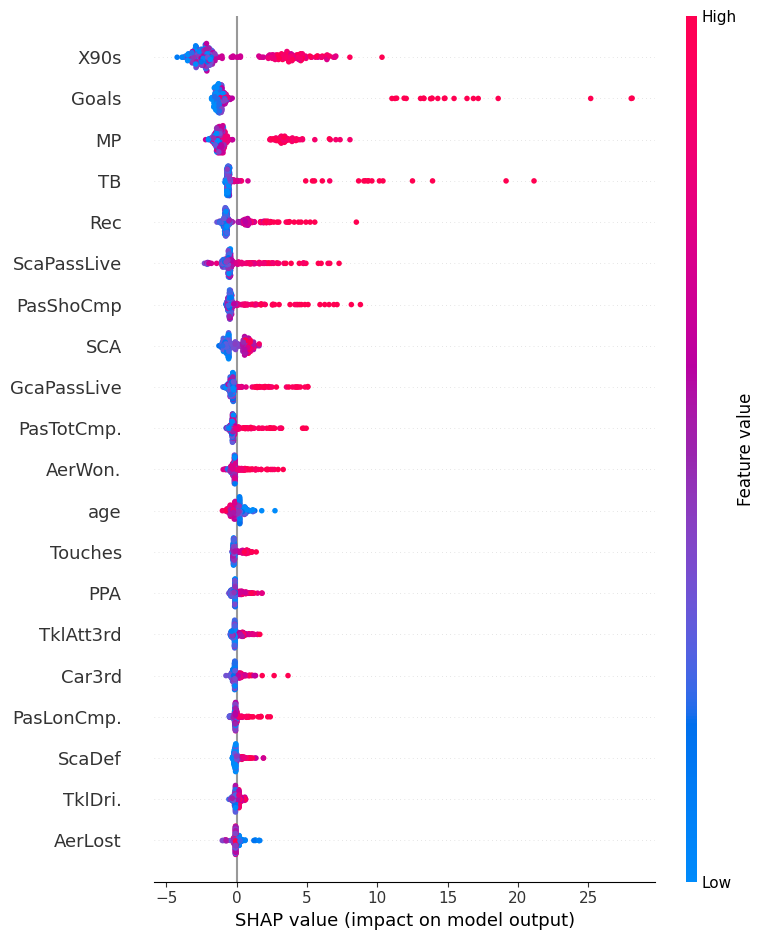

In [8]:
# Importa la biblioteca SHAP
#!pip install shap
import shap

# Crear un objeto explicador SHAP con el mejor modelo
explainer = shap.Explainer(best_rf_model)

# Calcular los valores SHAP para el conjunto de entrenamiento
shap_values = explainer.shap_values(X_train)

# Graficar un resumen de los valores SHAP
shap.summary_plot(shap_values, X_train)



# Predicciones

In [ ]:
predicciones = best_rf_model.predict(df.drop(columns=['value']))
df['value_pred'] = predicciones
df.head()

,value,age,MP,X90s,Goals,Shots,SoT,SoT.,G.Sh,G.SoT,...,Off,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon.,G.MP,value_pred
0,15.0,21,16,10.8,3,1.11,0.37,33.3,0.17,0.50,...,0.19,0.00,0.00,0.0,4.44,0.83,1.67,33.3,0.277778,14.876791
1,10.0,26,21,20.3,0,1.23,0.54,44.0,0.00,0.00,...,0.00,0.00,0.00,0.0,4.78,0.44,0.25,64.3,0.000000,28.418117
2,20.0,22,18,11.5,4,2.96,1.13,38.2,0.12,0.31,...,0.09,0.09,0.09,0.0,5.22,0.00,0.87,0.0,0.347826,23.279780
3,3.0,31,19,13.6,3,0.88,0.51,58.3,0.17,0.29,...,0.00,0.00,0.00,0.0,4.49,0.66,1.32,33.3,0.220588,13.763379
4,2.5,26,5,1.5,0,0.67,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.0,3.33,1.33,1.33,50.0,0.000000,26.167775


# Jugadores sobre / sub valorados

In [ ]:
df['diferencia'] = df['value_pred']-df['value']

df['valorizacion'] = np.where(df['diferencia']>11,'Subvalorado',np.where(df['diferencia']<-11,'Sobrevalorado',''))
df.head(50)
#df[df['valorizacion'] == 'Sobrevalorado'].count()


,value,age,MP,X90s,Goals,Shots,SoT,SoT.,G.Sh,G.SoT,...,PKcon,OG,Recov,AerWon,AerLost,AerWon.,G.MP,value_pred,diferencia,valorizacion
0,15.0,21,16,10.8,3,1.11,0.37,33.3,0.17,0.50,...,0.00,0.00,4.44,0.83,1.67,33.3,0.277778,14.876791,-0.123209,
1,10.0,26,21,20.3,0,1.23,0.54,44.0,0.00,0.00,...,0.00,0.00,4.78,0.44,0.25,64.3,0.000000,28.418117,18.418117,Subvalorado
2,20.0,22,18,11.5,4,2.96,1.13,38.2,0.12,0.31,...,0.09,0.00,5.22,0.00,0.87,0.0,0.347826,23.279780,3.279780,
3,3.0,31,19,13.6,3,0.88,0.51,58.3,0.17,0.29,...,0.00,0.00,4.49,0.66,1.32,33.3,0.220588,13.763379,10.763379,
4,2.5,26,5,1.5,0,0.67,0.00,0.0,0.00,0.00,...,0.00,0.00,3.33,1.33,1.33,50.0,0.000000,26.167775,23.667775,Subvalorado
5,2.5,34,8,3.4,0,1.18,0.29,25.0,0.00,0.00,...,0.00,0.00,5.88,0.59,0.29,66.7,0.000000,25.539380,23.039380,Subvalorado
6,2.5,26,18,7.1,0,1.41,0.70,50.0,0.00,0.00,...,0.14,0.00,7.04,0.56,0.99,36.4,0.000000,13.270981,10.770981,
7,90.0,23,16,11.8,0,1.44,0.17,11.8,0.00,0.00,...,0.00,0.00,5.00,2.29,0.93,71.1,0.000000,34.872790,-55.127210,Sobrevalorado
8,5.0,21,6,1.2,0,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,5.83,0.00,1.67,0.0,0.000000,14.756532,9.756532,
9,15.0,24,14,9.3,0,0.11,0.00,0.0,0.00,0.00,...,0.00,0.00,6.67,0.97,0.97,50.0,0.000000,14.198149,-0.801851,


# Gráfico comparativo valor real vs predicción

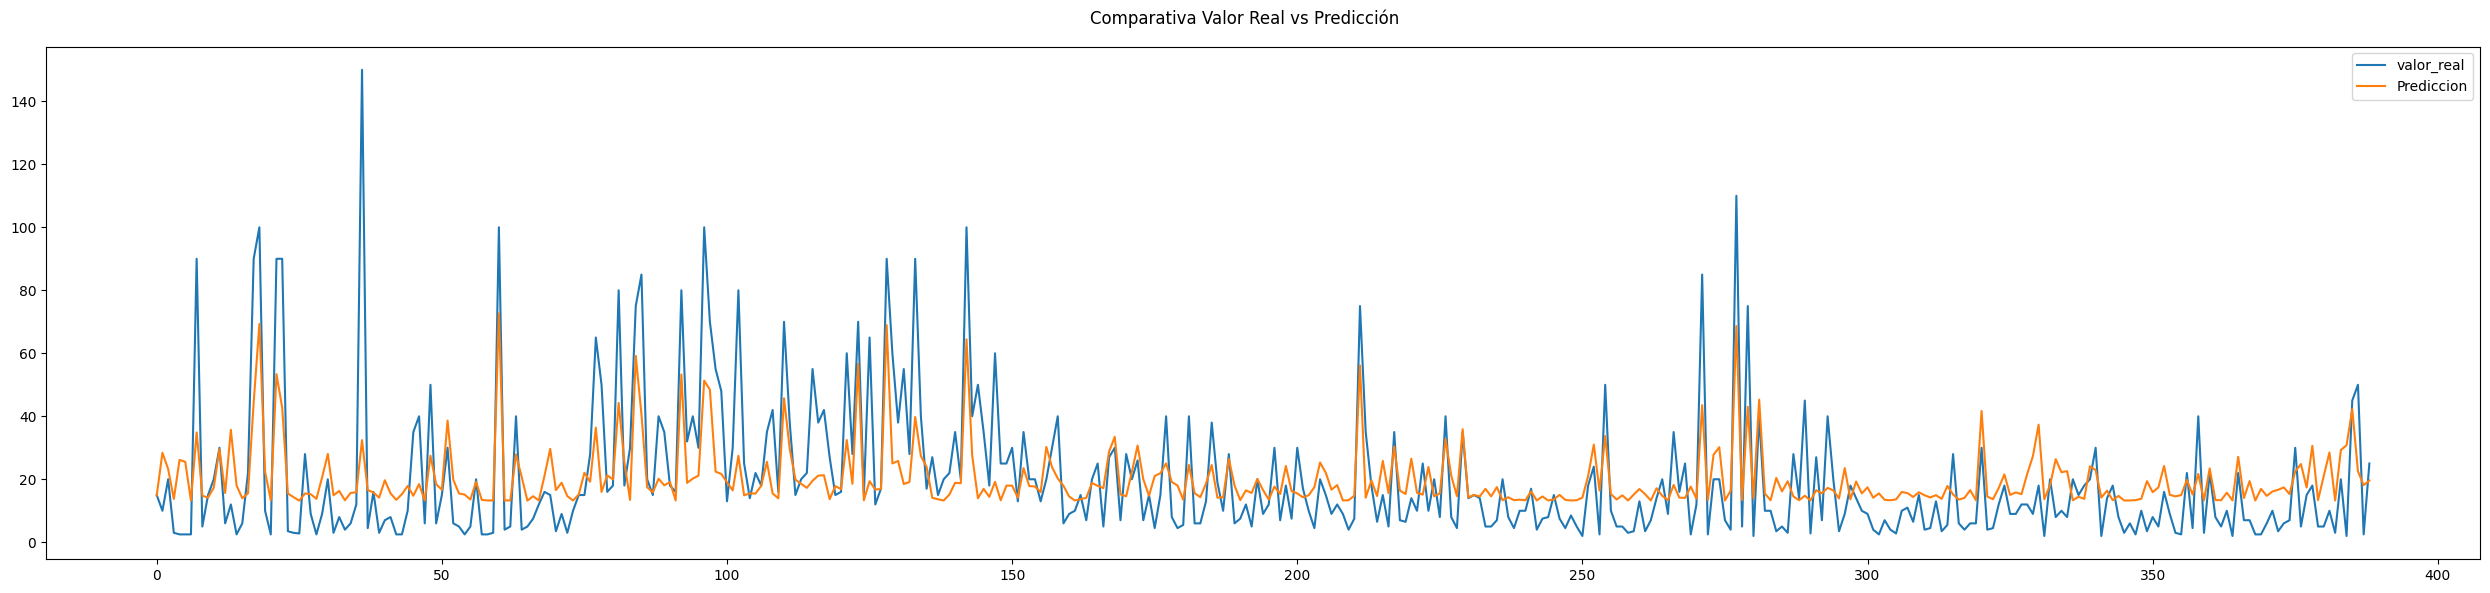

In [ ]:
plt.figure(figsize=(25, 6))
df["value"].plot(label="valor_real")
df["value_pred"].plot(label="Prediccion")

plt.suptitle("Comparativa Valor Real vs Predicción")
plt.legend()
plt.tight_layout()
plt.show();

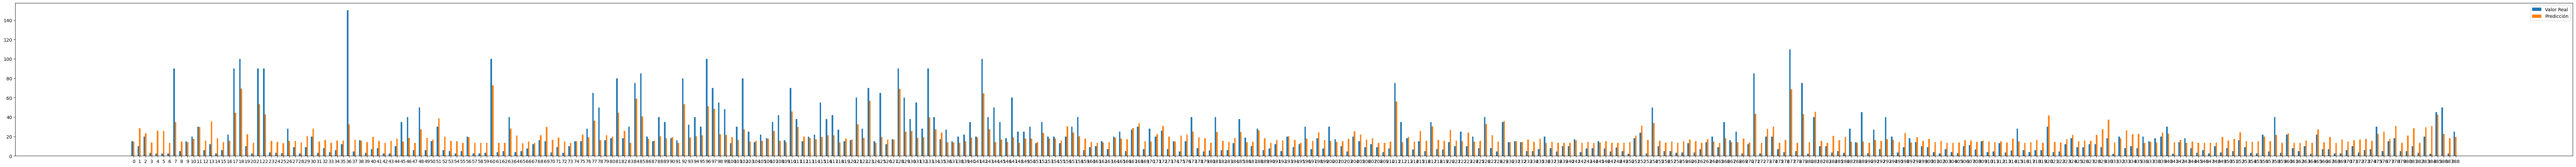

In [ ]:
import numpy as np

n = len(df.index)
x = np.arange(n)
width = 0.25
plt.figure(figsize=(100, 6))
plt.bar(x - width, df.value, width=width, label='Valor Real')
plt.bar(x, df.value_pred, width=width, label='Predicción')
plt.xticks(x, df.index)
plt.legend(loc='best')
plt.show()